In [17]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model, Sequential
from keras import backend as K
from keras.layers import *
from keras.initializers import TruncatedNormal
from keras.regularizers import l2
from keras.callbacks import Callback
from keras import optimizers
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import time

In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
from SqueezeDetHelpers import fire_layer, binary_crossentropy, keras_binary_crossentropy

In [4]:
print(tf.__version__)

1.12.0


In [5]:
DATA_DIR = r"./data"
ANNOTATION_FILE = r"annot"
annotation = os.path.join(DATA_DIR, ANNOTATION_FILE)
print(annotation)

./data/annot


In [6]:
EPSILON = 1e-16

BATCHSIZE = 4

HEIGHT = 320
WIDTH = 320
CHANNELS = 3

WEIGHT_DECAY = 1e-3
KEEP_PROB = 0.5
CLASSES = 1

LABEL_WEIGHT = 5.0

In [7]:
input_layer = Input(shape=(HEIGHT, WIDTH, CHANNELS), name="input")
print(f"input: {input_layer.shape}")

conv1 = Conv2D(name='conv1', filters=128, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding="SAME",
               #use_bias=True,
               kernel_initializer=TruncatedNormal(stddev=0.01),
               kernel_regularizer=l2(WEIGHT_DECAY),
               )(input_layer)
print(f"conv1: {conv1.shape}")

pool1 = MaxPool2D(name="pool1", pool_size=(3, 3), strides=(2, 2), padding='SAME')(conv1)
print(f"pool1: {pool1.shape}")

fire1 = fire_layer(name="fire1", input=pool1, s1x1=32, e1x1=128, e3x3=128, weight_decay=WEIGHT_DECAY)
print(f"fire1: {fire1.shape}")

fire2 = fire_layer(name="fire2", input=fire1, s1x1=32, e1x1=128, e3x3=128, weight_decay=WEIGHT_DECAY)
print(f"fire2: {fire2.shape}")

pool2 = MaxPool2D(name="pool2", pool_size=(3, 3), strides=(2, 2), padding='SAME')(fire2)
print(f"pool2: {pool2.shape}")

fire3 = fire_layer(name="fire3", input=pool2, s1x1=48, e1x1=196, e3x3=196, weight_decay=WEIGHT_DECAY)
print(f"fire3: {fire3.shape}")

fire4 = fire_layer(name="fire4", input=fire3, s1x1=48, e1x1=196, e3x3=196, weight_decay=WEIGHT_DECAY)
print(f"fire4: {fire4.shape}")

up1 = UpSampling2D(name="up1", size=(2, 2), data_format=None, interpolation='nearest')(fire4)
print(f"up1: {up1.shape}")

fire5 = fire_layer(name="fire5", input=up1, s1x1=32, e1x1=128, e3x3=128, weight_decay=WEIGHT_DECAY)
print(f"fire5: {fire5.shape}")

fire6 = fire_layer(name="fire6", input=fire5, s1x1=32, e1x1=128, e3x3=128, weight_decay=WEIGHT_DECAY)
print(f"fire6: {fire6.shape}")

up2 = UpSampling2D(name="up2", size=(2, 2), data_format=None, interpolation='nearest')(fire6)
print(f"up2: {up2.shape}")

fire7 = fire_layer(name="fire7", input=up2, s1x1=32, e1x1=128, e3x3=128, weight_decay=WEIGHT_DECAY)
print(f"fire7: {fire7.shape}")

fire8 = fire_layer(name="fire8", input=fire7, s1x1=32, e1x1=128, e3x3=128, weight_decay=WEIGHT_DECAY)
print(f"fire8: {fire8.shape}")

up3 = UpSampling2D(name="up3", size=(2, 2), data_format=None, interpolation='nearest')(fire8)
print(f"up3: {up3.shape}")

"""
conv1 = Conv2D(name='conv1', filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="SAME",
               #use_bias=True,
               kernel_initializer=TruncatedNormal(stddev=0.01),
               #kernel_regularizer=l2(WEIGHT_DECAY),
               )(input_layer)
print(f"conv1: {conv1.shape}")

fire1 = fire_layer(name="fire1", input=conv1, s1x1=32, e1x1=128, e3x3=128, weight_decay=WEIGHT_DECAY)
print(f"fire1: {fire1.shape}")

fire2 = fire_layer(name="fire2", input=fire1, s1x1=32, e1x1=128, e3x3=128, weight_decay=WEIGHT_DECAY)
print(f"fire2: {fire2.shape}")

fire3 = fire_layer(name="fire3", input=fire2, s1x1=32, e1x1=128, e3x3=128, weight_decay=WEIGHT_DECAY)
print(f"fire3: {fire3.shape}")

fire4 = fire_layer(name="fire4", input=fire3, s1x1=32, e1x1=128, e3x3=128, weight_decay=WEIGHT_DECAY)
print(f"fire4: {fire4.shape}")
"""

preds = Conv2D(name='preds',
               filters=1,
               kernel_size=(1, 1),
               strides=(1, 1),
               activation='sigmoid',
               padding="SAME",
               kernel_initializer=TruncatedNormal(stddev=0.01),
               kernel_regularizer=l2(WEIGHT_DECAY)
               )(up3)
print(f"preds: {preds.shape}")

input: (?, 320, 320, 3)
conv1: (?, 160, 160, 128)
pool1: (?, 80, 80, 128)
fire1: (?, 80, 80, 256)
fire2: (?, 80, 80, 256)
pool2: (?, 40, 40, 256)
fire3: (?, 40, 40, 392)
fire4: (?, 40, 40, 392)
up1: (?, 80, 80, 392)
fire5: (?, 80, 80, 256)
fire6: (?, 80, 80, 256)
up2: (?, 160, 160, 256)
fire7: (?, 160, 160, 256)
fire8: (?, 160, 160, 256)
up3: (?, 320, 320, 256)
preds: (?, 320, 320, 1)


In [8]:
def loss(y_true, y_pred):
    # We are predicting a batchsize x anchorwidth x anchorheight x 3 output.
    #c_predictions = y_pred[:, :, :, 0]
    #c_labels = y_true[:, :, :, 0]

    # number of labels
    num_labels = K.sum(y_true)
    num_non_labels = HEIGHT * WIDTH - num_labels
    
    # Loss matrix for all entries
    loss_m_all = keras_binary_crossentropy(y_true, y_pred, EPSILON)
    
    # Loss matrix for the correct label
    loss_m_label = keras_binary_crossentropy(y_true, y_pred, EPSILON) * y_true
    
    # Loss matrix for non labels
    loss_m_nonlabel = loss_m_all - loss_m_label
    
    # Summing and adding weight to label loss
    c_loss_label = K.sum(
        loss_m_label
    ) / num_labels
    
    # summing and adding weight to non label loss
    c_loss_nonlabel = K.sum(
        loss_m_nonlabel
    ) / num_non_labels
    
    c_loss = c_loss_label * LABEL_WEIGHT + c_loss_nonlabel * (1 / LABEL_WEIGHT)
    
    total_loss = c_loss
    
    return total_loss

In [9]:
def load_data():
    
    with open(annotation, 'r') as f:
        lines = f.readlines()

    gt = np.zeros((len(lines), WIDTH, HEIGHT))
    
    for l in lines:
        obj = l.split(',')
        pic_id = int(obj[0].split('.')[0])
        x = int(obj[1])
        y = int(obj[2])
        
        gt[pic_id, x, y] = 1.0

    images = []
    
    for fi in os.listdir(DATA_DIR):
        if not fi.endswith('jpg'):
            continue
        im = cv2.imread(os.path.join(DATA_DIR, fi)) / 255.0
        images.append(im)
    
    return gt, np.array(images, dtype=np.float32)

labels, images = load_data()

In [10]:
class PrintInfo(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print(f"Learning rate with decay: {K.eval(lr_with_decay)}")
        #print(f"lr={K.eval(lr)}, decay={K.eval(decay)}")
        print("")
        
print_info = PrintInfo()

In [11]:
model = Model(inputs=input_layer, outputs=preds)

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 160, 128 3584        input[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 80, 80, 128)  0           conv1[0][0]                      
__________________________________________________________________________________________________
fire1/squeeze1x1 (Conv2D)       (None, 80, 80, 32)   4128        pool1[0][0]                      
__________________________________________________________________________________________________
fire1/expa

In [13]:
opt = optimizers.Adam(lr=1e-3, decay=1e-4) #, clipnorm=1.0)
#opt = optimizers.RMSprop(lr=0.001)#,  clipnorm=1.0)
#opt = optimizers.SGD(lr=1e-3, decay=1e-4, momentum=0.9, nesterov=False)
#opt = optimizers.Adagrad(lr=1e-3, decay=1e-3, clipnorm=1.0)
#opt =optimizers.SGD()
model.compile(loss=loss, optimizer=opt)

In [14]:
#model.fit(images.reshape(-1, 320, 320, 3), labels.reshape(-1, 2), batch_size=10, epochs=10, verbose=1)
model.fit(images.reshape(-1, WIDTH, HEIGHT, 3),
          labels.reshape(-1, WIDTH, HEIGHT, 1),
          batch_size=BATCHSIZE,
          epochs=100000,
          verbose=1,
          callbacks=[print_info])

Epoch 1/100000
10/10 [==============================] - 9s 905ms/step - loss: 3.9993
Learning rate with decay: 0.0009997000452131033

Epoch 2/100000
10/10 [==============================] - 1s 130ms/step - loss: 3.9754
Learning rate with decay: 0.0009994003921747208

Epoch 3/100000
10/10 [==============================] - 1s 130ms/step - loss: 3.9507
Learning rate with decay: 0.00099910085555166

Epoch 4/100000
10/10 [==============================] - 1s 131ms/step - loss: 3.9230
Learning rate with decay: 0.000998801551759243

Epoch 5/100000
10/10 [==============================] - 1s 131ms/step - loss: 3.8865
Learning rate with decay: 0.000998502247966826

Epoch 6/100000
10/10 [==============================] - 1s 131ms/step - loss: 3.8314
Learning rate with decay: 0.0009982032934203744

Epoch 7/100000
10/10 [==============================] - 1s 129ms/step - loss: 3.7412
Learning rate with decay: 0.0009979044552892447

Epoch 8/100000
10/10 [==============================] - 1s 130ms/s

KeyboardInterrupt: 

In [22]:
CHECK_IMAGE_INDEX = 0

before = time.time()
res = model.predict(images[CHECK_IMAGE_INDEX].reshape(1, 320, 320, 3)).reshape(WIDTH, HEIGHT, 1)
after = time.time()

print(f"Forward pass time: {after-before}")

np.mean(res)

Forward pass time: 0.05433082580566406


0.8818094

Max value: 0.8845643997192383
Number of values above or equal to 0.8845643997192383: 92404


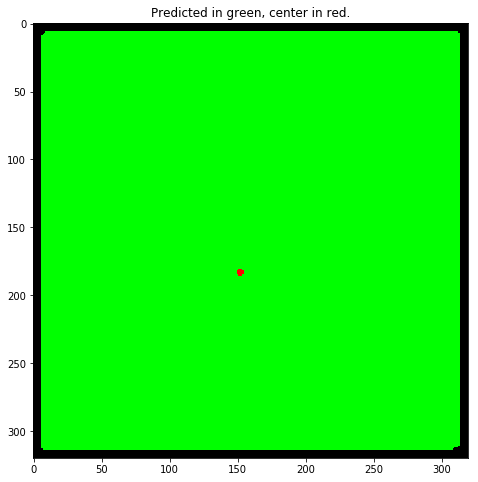

In [16]:
im_res = np.copy(images[CHECK_IMAGE_INDEX])
#print(np.max(im_res))
#im_res *= 255.0
#im_res = im_res.astype(np.uint8)

max_val = np.max(res)
print(f"Max value: {max_val}")
above_val = max_val
print(f"Number of values above or equal to {above_val}: {np.count_nonzero(res[:, :, 0] >= above_val)}")

pred_indicies = np.where(res[:, :, 0] >= above_val)
label_indices = np.where(labels[0])
#print(pred_indicies)
#print(label_indices)

for (x, y) in zip(pred_indicies[0], pred_indicies[1]):
    cv2.circle(im_res, (y, x), 1, (0, 1, 0), thickness=2)

x_label = label_indices[0][0]
y_label = label_indices[1][0]
cv2.circle(im_res, (y_label, x_label), 1, (1.0, 0, 0), thickness=2)
    
f = plt.figure(figsize=(15, 8))
plt.imshow(im_res)
plt.title("Predicted in green, center in red.")
plt.show()